## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("../../../../h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OGradientBoostingEstimator
from h2o.estimators import H2OUpliftRandomForestEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.35.0',projectVersion='3.35.0.99999',branch='maurever_PUBDEV-4940_uplift_trees_poc',lastCommitHash='8760916c9e1f20da963020fb7b7a6b7fd12269dc',gitDescribe='jenkins-master-5592-3-g8760916c9e',compiledOn='2021-10-09 16:33:48',compiledBy='potte'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 6 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024


In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OUpliftRandomForestEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                treatment_column=treatment_column,
                                                uplift_metric="KL",
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                auuc_type="gain"
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True,
                                      score_tree_interval=ntrees+1
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    start = time.time()
    gbm = H2OGradientBoostingEstimator(        
                                        ntrees=ntrees,
                                        max_depth=max_depth,
                                        distribution="bernoulli",
                                        gainslift_bins=10,
                                        min_rows=10,
                                        nbins_top_level=nbins_top_level,
                                        nbins=nbins,
                                        seed=seed,
                                        sample_rate=0.99,
                                        score_tree_interval=ntrees+1
                                      )
    gbm.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    gbm_time = end - start
    print(f"gbm Time: {gbm_time}s")    
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time, gbm_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    all_times_num_gbm = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        times_gbm = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time, gbm_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
            times_gbm.append(gbm_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        print(f"gbm {np.mean(times_gbm)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times_num_gbm.append(times_gbm)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s and gbm {np.mean(times_gbm)}s")

    uplift_means = dict()
    rf_means = dict()
    gbm_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}, gbm = {np.mean(all_times_num_gbm[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
        gbm_means[nthreads] = np.mean(all_times_num_gbm[i])
    
    return uplift_means, rf_means, gbm_means
        
    
def plot_result(eif_means, if_means, gbm_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    
        
    data_gbm = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_means.items():
        data_gbm["x"].append(label)
        data_gbm["y"].append(coord)         

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="UpliftRF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3)
    plt.plot(data_gbm['x'], data_gbm['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}; nbins = {nbins}")
    plt.savefig(f"h2o-scale-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [5]:
max_depths = []

In [6]:
N = 100000
P = 20
max_depth = 8
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
uplift_time7, rf_time7, gbm_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1mh6h0c8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1mh6h0c8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1mh6h0c8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 minutes
H2O_cluster_name:,H2O_from_python_potte_r49r84
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.39245891571045s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.30244779586792s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.443847417831421s
H2O session _sid_a111 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppsj28u9k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppsj28u9k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppsj28u9k\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 minutes
H2O_cluster_name:,H2O_from_python_potte_gp65dj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.899696588516235s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.658203840255737s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.281587362289429s
H2O session _sid_986d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwte3qfyy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwte3qfyy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwte3qfyy\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 minutes
H2O_cluster_name:,H2O_from_python_potte_nktrze
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.584826946258545s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.092629671096802s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.487789154052734s
H2O session _sid_b6e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpslh2w49j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpslh2w49j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpslh2w49j\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 minutes
H2O_cluster_name:,H2O_from_python_potte_11woh4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.442771434783936s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.773656845092773s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.243638515472412s
H2O session _sid_8ce2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbr5eg7ab
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbr5eg7ab\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbr5eg7ab\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 minutes
H2O_cluster_name:,H2O_from_python_potte_tq77lx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.91214919090271s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.24044919013977s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.057026863098145s
H2O session _sid_a15b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm7n31zp4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm7n31zp4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm7n31zp4\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_potte_orw87e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.688881158828735s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.222853422164917s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.167067766189575s
H2O session _sid_9cb0 closed.
Uplift 36.9867973725001s
RF 8.71504012743632s
gbm 12.780159513155619s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1tv3gp3j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1tv3gp3j\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 minutes
H2O_cluster_name:,H2O_from_python_potte_iveucx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.535956621170044s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.435835599899292s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.20218539237976s
H2O session _sid_88e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmaccti0v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmaccti0v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmaccti0v\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 minutes
H2O_cluster_name:,H2O_from_python_potte_491cvz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.654393672943115s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.873356103897095s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.005917072296143s
H2O session _sid_aee1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuvk05qh9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuvk05qh9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuvk05qh9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_potte_mhbua3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.255839586257935s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.296817779541016s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.999578952789307s
H2O session _sid_9bbc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7bd18e3o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7bd18e3o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7bd18e3o\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 minutes
H2O_cluster_name:,H2O_from_python_potte_rrc2hu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.46376132965088s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.603098154067993s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.965873003005981s
H2O session _sid_adb9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv9p6ofpg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv9p6ofpg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv9p6ofpg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 minutes
H2O_cluster_name:,H2O_from_python_potte_h8b52b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.454378843307495s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.282798528671265s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.20270323753357s
H2O session _sid_86b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnx9xrlqz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnx9xrlqz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnx9xrlqz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 minutes
H2O_cluster_name:,H2O_from_python_potte_5mjvbh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.12760090827942s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.672051668167114s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.028165102005005s
H2O session _sid_8efb closed.
Uplift 35.58198849360148s
RF 8.527326305707296s
gbm 12.067403793334961s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5j6nkklf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5j6nkklf\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 minutes
H2O_cluster_name:,H2O_from_python_potte_6xr4r1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.19092631340027s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.46364712715149s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.663512945175171s
H2O session _sid_9cfc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7qalunv0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7qalunv0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7qalunv0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,24 minutes
H2O_cluster_name:,H2O_from_python_potte_vmla6d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.39833211898804s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.69861364364624s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.109415292739868s
H2O session _sid_8378 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpys1c3k23
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpys1c3k23\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpys1c3k23\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_potte_w465to
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.89018249511719s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.712479591369629s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.614768266677856s
H2O session _sid_a58a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpksx8ruxr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpksx8ruxr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpksx8ruxr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,26 minutes
H2O_cluster_name:,H2O_from_python_potte_kfkt75
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.030877351760864s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.453442096710205s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.86964464187622s
H2O session _sid_9b6f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4p533o96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4p533o96\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4p533o96\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,28 minutes
H2O_cluster_name:,H2O_from_python_potte_oarigu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.15913009643555s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.337380170822144s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.790011644363403s
H2O session _sid_b200 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpem62mw61
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpem62mw61\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpem62mw61\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,29 minutes
H2O_cluster_name:,H2O_from_python_potte_tj3hqe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.338865518569946s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.440349578857422s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.708756685256958s
H2O session _sid_95f8 closed.
Uplift 35.83471898237864s
RF 8.517652034759521s
gbm 11.79268491268158s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9o12nh4u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9o12nh4u\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,30 minutes
H2O_cluster_name:,H2O_from_python_potte_75o5xa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.90406394004822s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.495699405670166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.761874675750732s
H2O session _sid_b5ca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxqjcmbtn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxqjcmbtn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxqjcmbtn\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,32 minutes
H2O_cluster_name:,H2O_from_python_potte_fl0a12
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.970417737960815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.622342824935913s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 10.966184854507446s
H2O session _sid_95fe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp90j6cxss
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp90j6cxss\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp90j6cxss\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,33 minutes
H2O_cluster_name:,H2O_from_python_potte_zqh5eg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.62766408920288s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.484483242034912s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.77804946899414s
H2O session _sid_a0d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpevzkj820
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpevzkj820\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpevzkj820\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,34 minutes
H2O_cluster_name:,H2O_from_python_potte_9j2w9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.548155307769775s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.642840385437012s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.016878604888916s
H2O session _sid_9be6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl9b2xihk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl9b2xihk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl9b2xihk\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,36 minutes
H2O_cluster_name:,H2O_from_python_potte_ecgwg2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.52157139778137s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.725949764251709s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.688671350479126s
H2O session _sid_8b81 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu2lobl6v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu2lobl6v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu2lobl6v\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,37 minutes
H2O_cluster_name:,H2O_from_python_potte_ce805g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.53905200958252s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.644226312637329s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.558432817459106s
H2O session _sid_97c4 closed.
Uplift 36.68515408039093s
RF 8.602590322494507s
gbm 11.461681962013245s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsoi9i80_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsoi9i80_\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,38 minutes
H2O_cluster_name:,H2O_from_python_potte_2mbzim
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.777997732162476s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.783405780792236s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.869715929031372s
H2O session _sid_b012 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgw9jtxse
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgw9jtxse\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgw9jtxse\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,40 minutes
H2O_cluster_name:,H2O_from_python_potte_f7qy07
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.09261107444763s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.766132831573486s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.925563335418701s
H2O session _sid_b7e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsohezcau
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsohezcau\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsohezcau\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,41 minutes
H2O_cluster_name:,H2O_from_python_potte_qha4o1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.51278567314148s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.811949968338013s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.886788606643677s
H2O session _sid_91e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpat4gjz6_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpat4gjz6_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpat4gjz6_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_xd1pp4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.94262742996216s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.777934551239014s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.901536464691162s
H2O session _sid_b22a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjno513h0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjno513h0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjno513h0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_5ovh0h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.43081045150757s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.680783748626709s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.861348867416382s
H2O session _sid_a184 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpda82ky8i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpda82ky8i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpda82ky8i\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,46 minutes
H2O_cluster_name:,H2O_from_python_potte_beuwbd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.76331663131714s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.835244178771973s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.854962825775146s
H2O session _sid_98c7 closed.
Uplift 40.920024832089744s
RF 9.775908509890238s
gbm 12.88331933816274s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdl8detn_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdl8detn_\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,47 minutes
H2O_cluster_name:,H2O_from_python_potte_4lo2hi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.46693992614746s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.104637384414673s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.469672918319702s
H2O session _sid_b733 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr3h6q_gx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr3h6q_gx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr3h6q_gx\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_potte_i2asm0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.47486901283264s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.232857942581177s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.490338802337646s
H2O session _sid_9714 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdcjvmxm8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdcjvmxm8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdcjvmxm8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_r2bj0c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.807801246643066s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.10566759109497s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.37393021583557s
H2O session _sid_b135 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz1jvjmx0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz1jvjmx0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz1jvjmx0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_zfmc3s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.308542251586914s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.242380380630493s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.640207767486572s
H2O session _sid_9cb7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptuq73wnf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptuq73wnf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptuq73wnf\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_vxnolm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.13009977340698s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.163698673248291s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.706900596618652s
H2O session _sid_89bd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpishu3fn8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpishu3fn8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpishu3fn8\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_potte_72vmcd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.77290964126587s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.32663345336914s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.51310920715332s
H2O session _sid_82ff closed.
Uplift 62.326860308647156s
RF 15.195979237556458s
gbm 20.532359917958576s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppc5jlhdy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppc5jlhdy\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,59 minutes
H2O_cluster_name:,H2O_from_python_potte_htp0v6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.90918684005737s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.1200053691864s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.24784064292908s
H2O session _sid_b394 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgaljvgqt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgaljvgqt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgaljvgqt\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_gnpbea
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.32316589355469s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.19609308242798s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.24304175376892s
H2O session _sid_adef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5scw75hx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5scw75hx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5scw75hx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_ez4u26
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.01498460769653s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 28.0426504611969s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.42600989341736s
H2O session _sid_b087 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdht33n_g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdht33n_g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdht33n_g\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_kl68g8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.94030833244324s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 28.064561128616333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 37.27069664001465s
H2O session _sid_b5d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpczc9y457
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpczc9y457\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpczc9y457\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_vmfliq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.55524826049805s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.01535654067993s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 35.44137620925903s
H2O session _sid_9400 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjvd6mcgy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjvd6mcgy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjvd6mcgy\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_mmbuly
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.79077959060669s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.125924587249756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.21697449684143s
H2O session _sid_bbc5 closed.
Uplift 106.58894558747609s
RF 27.42743186155955s
gbm 36.307656606038414s
12 - Uplift = 36.9867973725001, RF = 8.71504012743632, gbm = 12.780159513155619
10 - Uplift = 35.58198849360148, RF = 8.527326305707296, gbm = 12.067403793334961
8 - Uplift = 35.83471898237864, RF = 8.517652034759521, gbm = 11.79268491268158
6 - Uplift = 36.68515408039093, RF = 8.602590322494507, gbm = 11.461681962013245
4 - Uplift = 40.920024832089744, RF = 9.775908509890238, gbm = 12.88331933816274
2 - Uplift = 62.326860

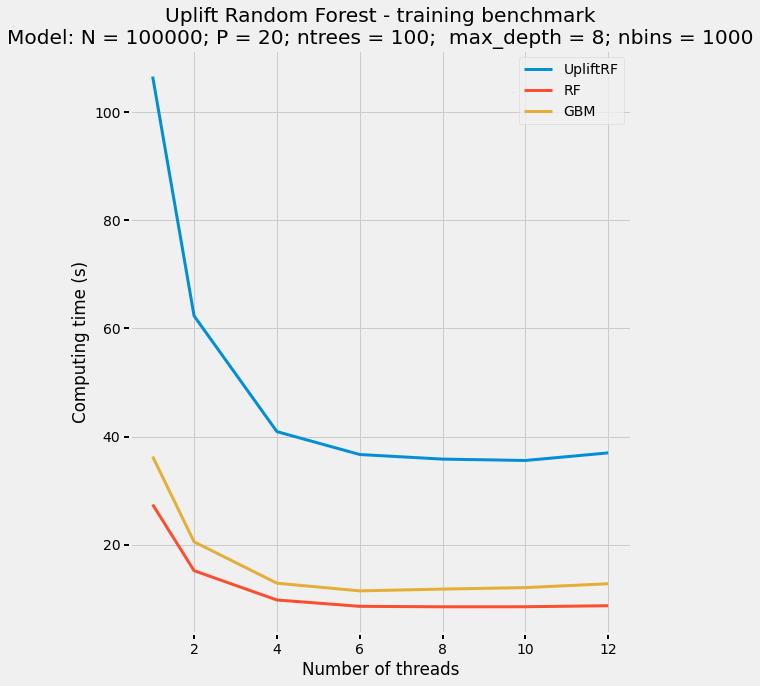

In [8]:
plot_result(uplift_time7, rf_time7, gbm_time7)

In [9]:
N = 100000
P = 20
max_depth = 16
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
uplift_time8, rf_time8, gbm_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9nzs0g_2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9nzs0g_2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9nzs0g_2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_c1l2dr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 209.70019602775574s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.61590504646301s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.0265245437622s
H2O session _sid_baa9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp179p5zuw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp179p5zuw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp179p5zuw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_32oea0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 210.25340723991394s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.7866153717041s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.70272612571716s
H2O session _sid_9190 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0dlmx87d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0dlmx87d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0dlmx87d\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_tfi0aw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 207.78287267684937s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.2594575881958s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.56314945220947s
H2O session _sid_94fa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvuuxkhbv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvuuxkhbv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvuuxkhbv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_yfu50x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 208.28736400604248s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.89249515533447s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.78264164924622s
H2O session _sid_9b51 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbvb5g6lj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbvb5g6lj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbvb5g6lj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_hit0m8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 207.8903877735138s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.5011658668518s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 177.86136269569397s
H2O session _sid_8574 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_93d68lh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_93d68lh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_93d68lh\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_6bcnx0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 219.6606695652008s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.47046780586243s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 184.88538599014282s
H2O session _sid_b0cd closed.
Uplift 210.59581621487936s
RF 65.42101780573527s
gbm 164.63696507612863s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp76wmkokw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp76wmkokw\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_a0y2bv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 203.9271399974823s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.14861917495728s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 149.8844861984253s
H2O session _sid_ad79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi2cnb1wz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi2cnb1wz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi2cnb1wz\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_6lxnwb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 206.12059998512268s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.16010403633118s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 148.64210414886475s
H2O session _sid_9663 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplz1ma955
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplz1ma955\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplz1ma955\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_77cz61
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 206.5945746898651s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.38485336303711s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 148.7623245716095s
H2O session _sid_aa9e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3i43kras
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3i43kras\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3i43kras\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_sk22fd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 207.58422183990479s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.04654479026794s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 148.88277959823608s
H2O session _sid_9b51 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplyne371p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplyne371p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplyne371p\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_pslv2z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 200.31161522865295s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.90812706947327s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 149.29939651489258s
H2O session _sid_8fa9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_uhry0f9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_uhry0f9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_uhry0f9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_rh5897
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 200.25448346138s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.96585392951965s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.78346252441406s
H2O session _sid_8d11 closed.
Uplift 204.13210586706796s
RF 63.935683727264404s
gbm 148.20909225940704s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmxqf357w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmxqf357w\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_fjiyne
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 185.98957324028015s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.496477365493774s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.70697474479675s
H2O session _sid_99ea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6codevo3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6codevo3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6codevo3\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_p7kbth
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 189.76641154289246s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.227879762649536s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.8642497062683s
H2O session _sid_bf66 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvitxnmaj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvitxnmaj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvitxnmaj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_k1r1m1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 186.87369108200073s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.269450187683105s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.2017674446106s
H2O session _sid_8db8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprjmxayvo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprjmxayvo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprjmxayvo\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_ets2rz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 187.24323844909668s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.094003677368164s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 133.13014769554138s
H2O session _sid_8a67 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_w3yvq0r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_w3yvq0r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_w3yvq0r\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_ztio1x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 187.54964351654053s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.10364842414856s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.64398574829102s
H2O session _sid_be96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprgvyd68a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprgvyd68a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprgvyd68a\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_stpudy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 186.94425249099731s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.19165802001953s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.02156949043274s
H2O session _sid_b2f9 closed.
Uplift 187.394468386968s
RF 54.230519572893776s
gbm 133.5947824716568s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ojj1hlp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ojj1hlp\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_okpu0t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 185.32729649543762s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.82579278945923s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.8481080532074s
H2O session _sid_a6fb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp58fbjktb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp58fbjktb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp58fbjktb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_waczzl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.9263412952423s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.82805776596069s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.88262867927551s
H2O session _sid_b1ec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm9m76i3q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm9m76i3q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm9m76i3q\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_ezwdut
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.83016395568848s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.98027563095093s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 124.21253752708435s
H2O session _sid_8861 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqe02es48
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqe02es48\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqe02es48\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_62lcub
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.01204419136047s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.706483364105225s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.10514521598816s
H2O session _sid_80c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgxuhaj7k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgxuhaj7k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgxuhaj7k\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_m0gj37
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.70847535133362s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.81442880630493s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 124.36235213279724s
H2O session _sid_8515 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkharpawl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkharpawl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkharpawl\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_9da7bi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.42215061187744s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.15725564956665s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 124.06255173683167s
H2O session _sid_887f closed.
Uplift 182.53774531682333s
RF 50.885382334391274s
gbm 123.91222055753072s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjr0fb3aa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjr0fb3aa\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_yyy1u1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.68843865394592s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.03116250038147s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.69961738586426s
H2O session _sid_a5e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxu1ryknd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxu1ryknd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxu1ryknd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_qss59c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.5828001499176s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.11784863471985s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 116.21907162666321s
H2O session _sid_9c18 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt3qv9zpt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt3qv9zpt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt3qv9zpt\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_ti8z1q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.8941686153412s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.208715200424194s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.91825866699219s
H2O session _sid_a597 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbnwh7c9s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbnwh7c9s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbnwh7c9s\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_vjl6rn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 186.07335209846497s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.40530562400818s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.33981013298035s
H2O session _sid_9819 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph_hjuf05
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph_hjuf05\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph_hjuf05\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_m4c6dr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.77102971076965s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.17937445640564s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.99705862998962s
H2O session _sid_8a96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfhv71twd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfhv71twd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfhv71twd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_rht3on
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.56167721748352s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.319578409194946s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 115.3903477191925s
H2O session _sid_b03c closed.
Uplift 184.5952444076538s
RF 52.87699747085571s
gbm 114.92736069361369s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcqqexqo1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcqqexqo1\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_20tz7s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.92199444770813s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.30485105514526s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 138.55541467666626s
H2O session _sid_b06e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9jqy7vrd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9jqy7vrd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9jqy7vrd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_cwvfji
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.99921226501465s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.90344262123108s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.92681622505188s
H2O session _sid_921b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa4ghk7fv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa4ghk7fv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa4ghk7fv\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_0d38tg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 265.50724697113037s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.54034757614136s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.5869963169098s
H2O session _sid_a3a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_mu33u33
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_mu33u33\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_mu33u33\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_twbw9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.2853972911835s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.36457538604736s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 139.47785830497742s
H2O session _sid_8bd8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9mwv7dh0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9mwv7dh0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9mwv7dh0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_16zh9p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.7542860507965s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 79.00239181518555s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 140.69268584251404s
H2O session _sid_8867 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjsd44g7c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjsd44g7c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjsd44g7c\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_017bxr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.27501010894775s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.67911672592163s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 140.80576181411743s
H2O session _sid_8bf4 closed.
Uplift 267.6238578557968s
RF 78.13245419661204s
gbm 139.67425553003946s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9n9rab20
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9n9rab20\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_m2tk2e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 452.5297050476074s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.95318174362183s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 219.27550792694092s
H2O session _sid_ae8b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzy9m_69u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzy9m_69u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzy9m_69u\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_h4lxif
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 459.1443738937378s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 148.04822325706482s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 221.1476354598999s
H2O session _sid_95a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4imxk4bi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4imxk4bi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4imxk4bi\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_um3jic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 459.2013535499573s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.79911303520203s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.43008661270142s
H2O session _sid_8d3a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6hhzucx9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6hhzucx9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6hhzucx9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_1kdmop
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 453.4510967731476s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.72227501869202s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.33066391944885s
H2O session _sid_8dbe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_pcw9hya
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_pcw9hya\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_pcw9hya\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_16wj6v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 453.926837682724s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 148.87774467468262s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 225.15365314483643s
H2O session _sid_8992 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp75jfcpti
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp75jfcpti\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp75jfcpti\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_aatim1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 451.122198343277s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.64584517478943s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 216.32439708709717s
H2O session _sid_a1c7 closed.
Uplift 454.8959275484085s
RF 147.0077304840088s
gbm 220.77699069182077s
12 - Uplift = 210.59581621487936, RF = 65.42101780573527, gbm = 164.63696507612863
10 - Uplift = 204.13210586706796, RF = 63.935683727264404, gbm = 148.20909225940704
8 - Uplift = 187.394468386968, RF = 54.230519572893776, gbm = 133.5947824716568
6 - Uplift = 182.53774531682333, RF = 50.885382334391274, gbm = 123.91222055753072
4 - Uplift = 184.5952444076538, RF = 52.87699747085571, gbm = 114.92736069361369
2 - Uplift = 267.

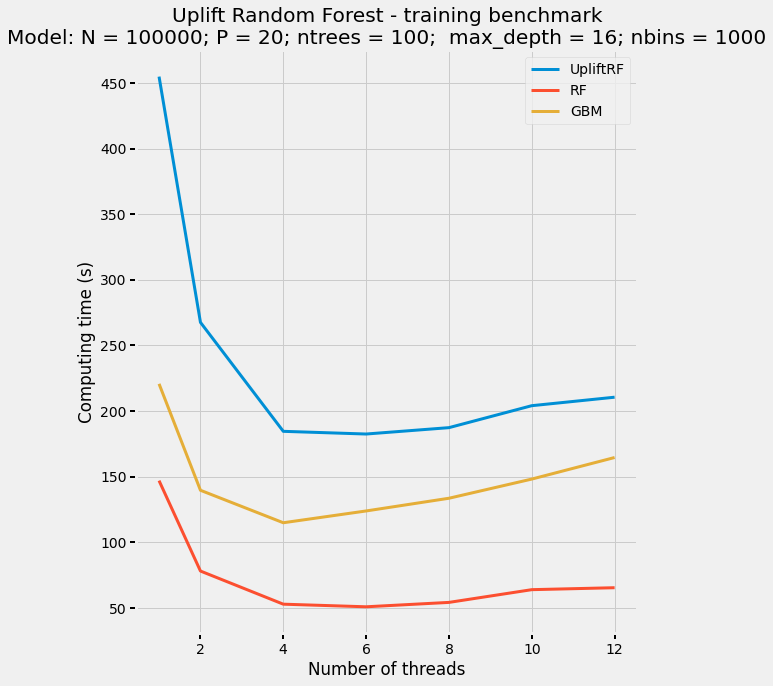

In [11]:
plot_result(uplift_time8, rf_time8, gbm_time8)

### Bigger sample_size

In [12]:
N = 100000
P = 20
max_depth = 20
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
uplift_time9, rf_time9, gbm_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_of2b1ij
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_of2b1ij\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_of2b1ij\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours
H2O_cluster_name:,H2O_from_python_potte_rtrmku
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.4663484096527s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.75447797775269s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 286.5557725429535s
H2O session _sid_8177 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx3jsv2vu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx3jsv2vu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx3jsv2vu\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_3zmmgq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 321.6597263813019s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.62964963912964s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 285.0444416999817s
H2O session _sid_a231 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi_isizkc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi_isizkc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi_isizkc\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_pe7xs5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 323.0976161956787s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.90796637535095s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 283.12310433387756s
H2O session _sid_8732 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp91baz14x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp91baz14x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp91baz14x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_udd7lh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 319.4003438949585s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.7296974658966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 285.39433097839355s
H2O session _sid_b89b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprvsvh8vg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprvsvh8vg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprvsvh8vg\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_3gt4y8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 318.8140163421631s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.75385093688965s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 289.8661959171295s
H2O session _sid_92d4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqp4crx2_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqp4crx2_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqp4crx2_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_bvzsq0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 323.22388315200806s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.76797580718994s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 287.95490646362305s
H2O session _sid_9773 closed.
Uplift 321.1103223959605s
RF 75.42393636703491s
gbm 286.3231253226598s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaymgizi6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaymgizi6\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_0bkzpl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.4801695346832s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.6813805103302s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.8726613521576s
H2O session _sid_b534 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe_hezrlt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe_hezrlt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe_hezrlt\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_4phpby
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.9719831943512s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.5940752029419s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 261.99817299842834s
H2O session _sid_8c21 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmhgzn6ik
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmhgzn6ik\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmhgzn6ik\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_wgtdeq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.07870626449585s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.57633018493652s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 260.06945729255676s
H2O session _sid_8dfa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp09hg4lxu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp09hg4lxu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp09hg4lxu\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_33evv0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.7400755882263s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.08079624176025s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 260.20433282852173s
H2O session _sid_82a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_06poh2n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_06poh2n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_06poh2n\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_ve8caa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 300.06079864501953s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.48891973495483s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.17202043533325s
H2O session _sid_a64e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5zndkf3m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5zndkf3m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5zndkf3m\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_0rvjwi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.7193937301636s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.58401918411255s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 261.45218086242676s
H2O session _sid_a03d closed.
Uplift 297.00852115948993s
RF 70.16758684317271s
gbm 260.46147096157074s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmqm5k5g0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmqm5k5g0\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_wrthx4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.34788846969604s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.39044046401978s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 241.28355717658997s
H2O session _sid_94e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp81ehczc3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp81ehczc3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp81ehczc3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_cx6itg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.1514148712158s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.4198088645935s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.239839553833s
H2O session _sid_b4f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpayy0m0cg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpayy0m0cg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpayy0m0cg\h2o_potte_started_from_python.err


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_5hukao
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.27936601638794s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.41472840309143s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.05295610427856s
H2O session _sid_8d45 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyssosiqq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyssosiqq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyssosiqq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_3p8pjh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.4985420703888s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.438720703125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.894549369812s
H2O session _sid_867d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwf1j2hdg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwf1j2hdg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwf1j2hdg\h2o_potte_started_from_python.err
 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_5s68uh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 286.10011982917786s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.44695901870728s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 234.57328915596008s
H2O session _sid_b573 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa2jebltk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa2jebltk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa2jebltk\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_sgcplg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 286.2972800731659s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.72621750831604s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.6292369365692s
H2O session _sid_8a0b closed.
Uplift 284.11243522167206s
RF 64.63947916030884s
gbm 238.61223804950714s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgxl215e_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgxl215e_\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_6uhsza
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 275.5422065258026s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.493765115737915s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 226.04751324653625s
H2O session _sid_b0e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpty9nhw6x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpty9nhw6x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpty9nhw6x\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_3x0n1w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.37463450431824s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.05632305145264s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 224.20542812347412s
H2O session _sid_82ad closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpynn4ad1q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpynn4ad1q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpynn4ad1q\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_3le1qz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.8050866127014s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.14308309555054s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 226.88137245178223s
H2O session _sid_91d0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ag9urti
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ag9urti\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ag9urti\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_g0uz8p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 275.9443025588989s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.04769253730774s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 226.50407218933105s
H2O session _sid_9b6a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph0gllyl0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph0gllyl0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph0gllyl0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_vec158
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.07838129997253s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.08922481536865s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 225.05227613449097s
H2O session _sid_b295 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7tu9uvf_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7tu9uvf_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7tu9uvf_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_dgtwpr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 276.19715452194214s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.05145049095154s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 225.78692245483398s
H2O session _sid_998b closed.
Uplift 274.65696100393933s
RF 61.8135898510615s
gbm 225.74626410007477s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpolv2sr0r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpolv2sr0r\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_tq9ldd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.1556177139282s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.70016527175903s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.2864589691162s
H2O session _sid_9ac0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9ucrkfq2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9ucrkfq2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9ucrkfq2\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_1srfm4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.3873372077942s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.43670678138733s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 200.77824878692627s
H2O session _sid_b45a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa99lyy9x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa99lyy9x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa99lyy9x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_bsfx0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.80482387542725s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.52357983589172s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 205.27037692070007s
H2O session _sid_8cc6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzs1g5enn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzs1g5enn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzs1g5enn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_ke3wjp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.0701792240143s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.126662731170654s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 202.7502248287201s
H2O session _sid_859d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4fmbqt45
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4fmbqt45\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4fmbqt45\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_hro6g9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 275.2218499183655s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.3184723854065s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.52794909477234s
H2O session _sid_9855 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa993qj5x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa993qj5x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa993qj5x\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_m4a4gh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 270.70478558540344s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.5674614906311s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.1022891998291s
H2O session _sid_bbd7 closed.
Uplift 271.55743225415546s
RF 64.27884141604106s
gbm 204.28592463334402s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnagby8mw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnagby8mw\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_h7u45o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 385.53773856163025s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.67092275619507s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 243.4649691581726s
H2O session _sid_b9d1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4lowqzrd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4lowqzrd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4lowqzrd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_98jt36
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 382.1825215816498s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.09921264648438s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 243.00372672080994s
H2O session _sid_b239 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_sp3kw9p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_sp3kw9p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_sp3kw9p\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_30w0cd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.39669275283813s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.83136415481567s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 243.40745782852173s
H2O session _sid_bc12 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprdjzddg7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprdjzddg7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprdjzddg7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_ts1dxm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 378.05836820602417s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.24494528770447s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.5479257106781s
H2O session _sid_a71f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp69gd_nq7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp69gd_nq7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp69gd_nq7\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_d5rhr7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 378.29399585723877s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.13894391059875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.36019825935364s
H2O session _sid_8caa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxxthoyss
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxxthoyss\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxxthoyss\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_k6wi3t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 386.16687202453613s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.04179549217224s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 243.06996488571167s
H2O session _sid_9d41 closed.
Uplift 382.2726981639862s
RF 95.5045307079951s
gbm 243.6423737605413s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyezzew3j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyezzew3j\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_t2b9yo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 643.9560482501984s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.4215338230133s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 365.8018522262573s
H2O session _sid_a74f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaw5e5j96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaw5e5j96\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaw5e5j96\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_2vjlqz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 648.1804769039154s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 178.60588026046753s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 368.2924165725708s
H2O session _sid_bfa4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzpqrldoy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzpqrldoy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzpqrldoy\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_n2njac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 658.1059741973877s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 179.38378953933716s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 372.58551359176636s
H2O session _sid_b13d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj2q_uhmv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj2q_uhmv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj2q_uhmv\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_kcednb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 648.5232357978821s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.18573832511902s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 376.4051525592804s
H2O session _sid_8a3d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5ilai0up
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5ilai0up\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5ilai0up\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_iuk1bg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 645.5838234424591s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 179.71476650238037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 371.7626242637634s
H2O session _sid_b44a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp22fhmb3a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp22fhmb3a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp22fhmb3a\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_acz7ec
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 656.7574677467346s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.3876256942749s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 373.77009439468384s
H2O session _sid_9140 closed.
Uplift 650.1845043897629s
RF 178.28322235743204s
gbm 371.436275601387s
12 - Uplift = 321.1103223959605, RF = 75.42393636703491, gbm = 286.3231253226598
10 - Uplift = 297.00852115948993, RF = 70.16758684317271, gbm = 260.46147096157074
8 - Uplift = 284.11243522167206, RF = 64.63947916030884, gbm = 238.61223804950714
6 - Uplift = 274.65696100393933, RF = 61.8135898510615, gbm = 225.74626410007477
4 - Uplift = 271.55743225415546, RF = 64.27884141604106, gbm = 204.28592463334402
2 - Uplift = 382.272

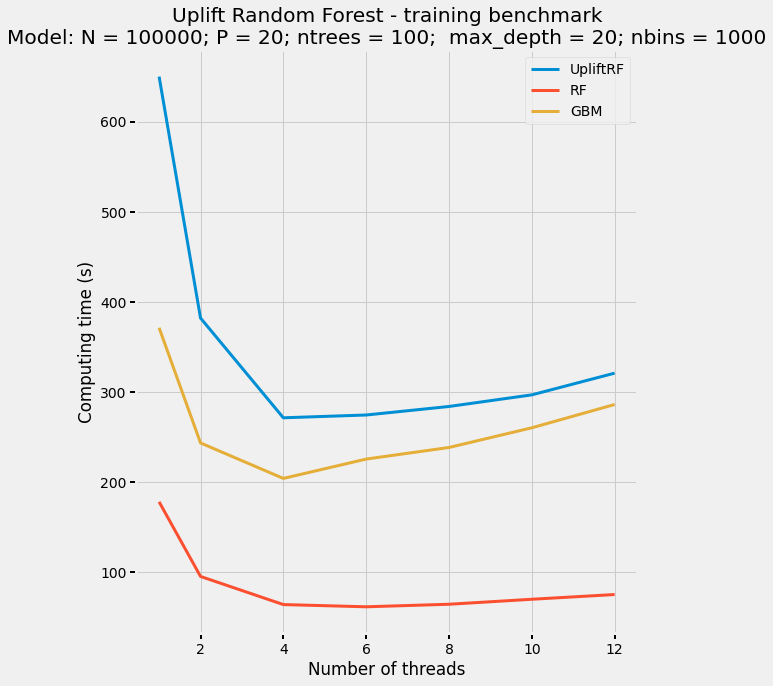

In [14]:
plot_result(uplift_time9, rf_time9, gbm_time9)

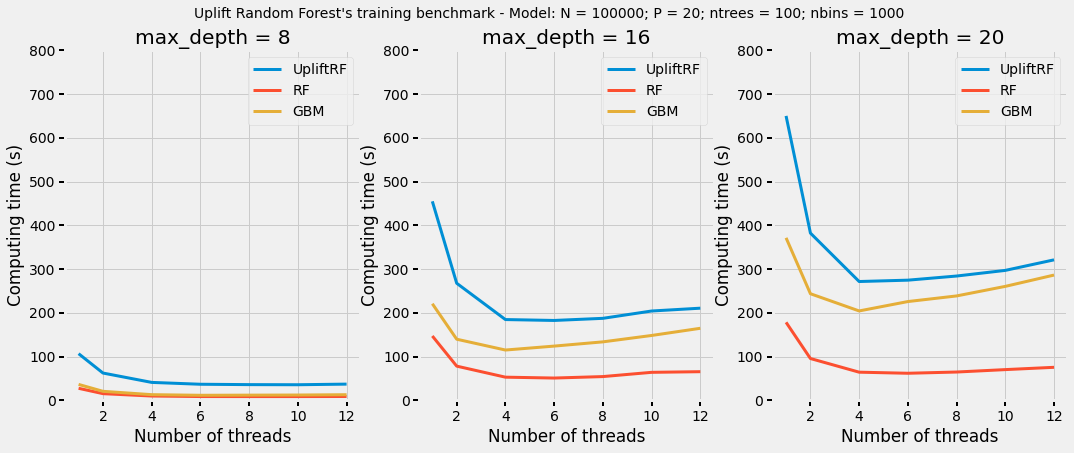

In [15]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 36.9867973725001, 10: 35.58198849360148, 8: 35.83471898237864, 6: 36.68515408039093, 4: 40.920024832089744, 2: 62.326860308647156, 1: 106.58894558747609}, {12: 210.59581621487936, 10: 204.13210586706796, 8: 187.394468386968, 6: 182.53774531682333, 4: 184.5952444076538, 2: 267.6238578557968, 1: 454.8959275484085}, {12: 321.1103223959605, 10: 297.00852115948993, 8: 284.11243522167206, 6: 274.65696100393933, 4: 271.55743225415546, 2: 382.2726981639862, 1: 650.1845043897629}]


In [17]:
print(all_predict_rf)

[{12: 8.71504012743632, 10: 8.527326305707296, 8: 8.517652034759521, 6: 8.602590322494507, 4: 9.775908509890238, 2: 15.195979237556458, 1: 27.42743186155955}, {12: 65.42101780573527, 10: 63.935683727264404, 8: 54.230519572893776, 6: 50.885382334391274, 4: 52.87699747085571, 2: 78.13245419661204, 1: 147.0077304840088}, {12: 75.42393636703491, 10: 70.16758684317271, 8: 64.63947916030884, 6: 61.8135898510615, 4: 64.27884141604106, 2: 95.5045307079951, 1: 178.28322235743204}]


In [18]:
print(all_predict_gbm)

[{12: 12.780159513155619, 10: 12.067403793334961, 8: 11.79268491268158, 6: 11.461681962013245, 4: 12.88331933816274, 2: 20.532359917958576, 1: 36.307656606038414}, {12: 164.63696507612863, 10: 148.20909225940704, 8: 133.5947824716568, 6: 123.91222055753072, 4: 114.92736069361369, 2: 139.67425553003946, 1: 220.77699069182077}, {12: 286.3231253226598, 10: 260.46147096157074, 8: 238.61223804950714, 6: 225.74626410007477, 4: 204.28592463334402, 2: 243.6423737605413, 1: 371.436275601387}]


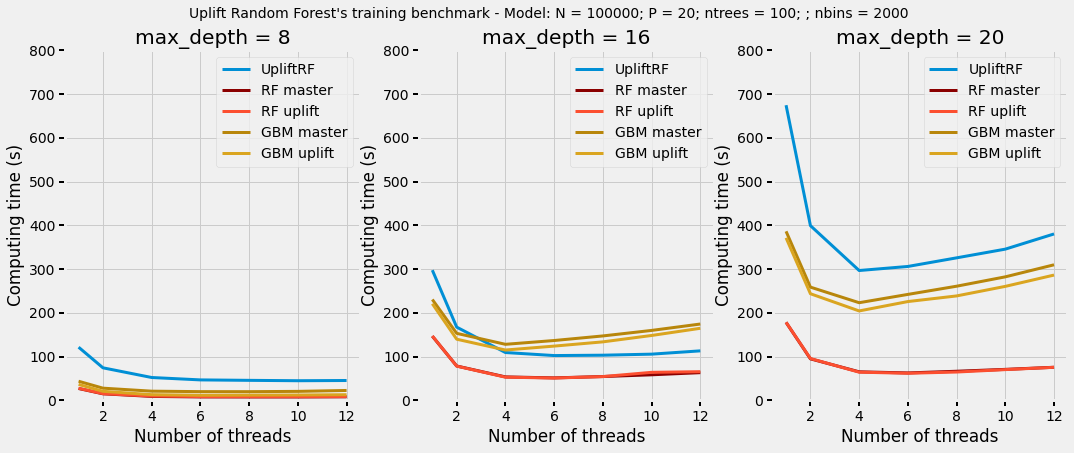

In [38]:
all_predict_uplift_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf_uplift = [rf_time7, rf_time8, rf_time9]
all_predict_gbm_uplift = [gbm_time7, gbm_time8, gbm_time9]
all_predict_gbm_master = [{12: 22.48334240913391, 10: 20.402833461761475, 8: 19.721631169319153, 6: 19.816392461458843, 4: 20.86631417274475, 2: 27.738888780275982, 1: 43.553764621416725}, {12: 174.38014920552573, 10: 159.74887490272522, 8: 147.15613889694214, 6: 136.68026411533356, 4: 128.00830761591592, 2: 153.07641053199768, 1: 230.45249466101328}, {12: 309.79658007621765, 10: 282.2613554795583, 8: 260.8332962195079, 6: 242.0995328028997, 4: 223.1113318602244, 2: 258.7484764258067, 1: 386.3171691099803}]
all_predict_rf_master = [{12: 7.952457348505656, 10: 7.589529991149902, 8: 7.599389672279358, 6: 7.7046345472335815, 4: 8.885488470395407, 2: 14.876623670260111, 1: 26.981343309084576}, {12: 63.210454185803734, 10: 58.30900597572327, 8: 54.306622544924416, 6: 51.23956127961477, 4: 53.46246202786764, 2: 78.41126509507497, 1: 146.63578669230142}, {12: 75.49273610115051, 10: 70.69829328854878, 8: 66.41124494870503, 6: 62.54522828261057, 4: 65.12324817975362, 2: 94.78704722722371, 1: 178.1989031235377}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; ; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color="darkgoldenrod")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 750)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [21]:
nbinss = []

In [22]:
N = 100000
P = 20
max_depth = 16
nbins=20
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [23]:
uplift_time0, rf_time0, gbm_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkqrau385
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkqrau385\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkqrau385\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_7iwev2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.57336449623108s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.3667573928833s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.500779628753662s
H2O session _sid_85f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6e_h3ffq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6e_h3ffq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6e_h3ffq\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_ufy4ap
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.37664723396301s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.835469961166382s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.508185863494873s
H2O session _sid_bf85 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp21kk01kn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp21kk01kn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp21kk01kn\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_8cpqcg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.589972496032715s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.860411882400513s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.859336853027344s
H2O session _sid_9d6a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqlviaonx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqlviaonx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqlviaonx\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_r7fw49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.31596875190735s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.84659218788147s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.85796093940735s
H2O session _sid_a42e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0mn1408_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0mn1408_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0mn1408_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_a26n4k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.71400308609009s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.76522970199585s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.051137447357178s
H2O session _sid_97eb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv9eq5qcb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv9eq5qcb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv9eq5qcb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_54niti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.95702052116394s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.88668155670166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.976220846176147s
H2O session _sid_b88d closed.
Uplift 45.2544960975647s
RF 17.760190447171528s
gbm 23.125603596369427s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpznuh541z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpznuh541z\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_uu7pdw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.59073829650879s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.912201166152954s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.81453585624695s
H2O session _sid_84fa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfy90mh_u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfy90mh_u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfy90mh_u\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_iq1u3g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.08973050117493s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.117632150650024s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.43110227584839s
H2O session _sid_aeff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8hk3sst3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8hk3sst3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8hk3sst3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_yb1h0l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.98476791381836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.572898626327515s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.62997341156006s
H2O session _sid_b587 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzp_fu0mz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzp_fu0mz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzp_fu0mz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_vtyxhl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.43205904960632s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.43697190284729s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.484980821609497s
H2O session _sid_8793 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpezob62fk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpezob62fk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpezob62fk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_njkjeb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.628621101379395s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.611268520355225s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.485339879989624s
H2O session _sid_bf67 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph1s98h2t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph1s98h2t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph1s98h2t\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_imxhee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.8037543296814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.449552536010742s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.591630935668945s
H2O session _sid_bbf0 closed.
Uplift 44.75494519869486s
RF 17.516754150390625s
gbm 22.572927196820576s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9yr3o1sd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9yr3o1sd\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_cpnzqe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.65836262702942s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.264248609542847s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.255587100982666s
H2O session _sid_b520 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpex2dwm5m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpex2dwm5m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpex2dwm5m\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_1pglj3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.96165084838867s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.36571192741394s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.50378656387329s
H2O session _sid_9750 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0b6ifsh1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0b6ifsh1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0b6ifsh1\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_0reqo5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.35199236869812s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.11086416244507s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.60657501220703s
H2O session _sid_862d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi20ln1e8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi20ln1e8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi20ln1e8\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_obob21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.11420798301697s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.152823448181152s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.326353549957275s
H2O session _sid_9535 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd1prvr7c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd1prvr7c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd1prvr7c\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_76ivg0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.752678632736206s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.07727813720703s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.415916204452515s
H2O session _sid_ad3b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_anrwhx5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_anrwhx5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_anrwhx5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_9jewa0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.83979320526123s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.963576316833496s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.439051866531372s
H2O session _sid_bdc8 closed.
Uplift 45.61311427752177s
RF 17.822417100270588s
gbm 22.25787838300069s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0ls3ib9u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0ls3ib9u\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_svhgur
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.309436321258545s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.350836992263794s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.80427646636963s
H2O session _sid_a243 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8wgh6s_4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8wgh6s_4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8wgh6s_4\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_65nk82
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.30392003059387s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.56284523010254s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.89843440055847s
H2O session _sid_b126 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpch3i8bg0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpch3i8bg0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpch3i8bg0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_9loyif
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.054802894592285s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.378512144088745s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.524172067642212s
H2O session _sid_b6f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb973ihv8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb973ihv8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb973ihv8\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_bm9z7j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.144548416137695s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.28362464904785s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.36298418045044s
H2O session _sid_80f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn46oktez
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn46oktez\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn46oktez\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_ymwnbg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.52631664276123s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.491241931915283s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.775513410568237s
H2O session _sid_bc6d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm88hdm4m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm88hdm4m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm88hdm4m\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_canxzd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.48858046531677s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.47297191619873s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.280208110809326s
H2O session _sid_917f closed.
Uplift 46.6379341284434s
RF 19.09000547726949s
gbm 23.107598106066387s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4nkwfa97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4nkwfa97\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_fdtbj8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.589743852615356s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.751908540725708s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.9517240524292s
H2O session _sid_ba73 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0ixl2uw8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0ixl2uw8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0ixl2uw8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_aar1j2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.577680826187134s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.866997957229614s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.961145639419556s
H2O session _sid_b27f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_nte7smx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_nte7smx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_nte7smx\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_9e5drk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 53.51491355895996s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 23.54874348640442s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.23076295852661s
H2O session _sid_a43f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2xbez9b4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2xbez9b4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2xbez9b4\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_kqjfo8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 53.07926797866821s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.662909746170044s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.0652174949646s
H2O session _sid_ba6a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfp28e0ob
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfp28e0ob\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfp28e0ob\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours
H2O_cluster_name:,H2O_from_python_potte_dk0wbr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.383206605911255s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.782945156097412s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.899648427963257s
H2O session _sid_b27b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpues8bvp8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpues8bvp8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpues8bvp8\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_i87a60
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.55496621131897s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.821765661239624s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.17480993270874s
H2O session _sid_9b19 closed.
Uplift 52.11662983894348s
RF 22.239211757977802s
gbm 26.047218084335327s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkh3vc1kv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkh3vc1kv\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_0ivtfc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.87893056869507s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.09198451042175s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.34273052215576s
H2O session _sid_ba32 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp75wkmd4v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp75wkmd4v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp75wkmd4v\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_lsfpxz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.88599371910095s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.59205722808838s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.58911371231079s
H2O session _sid_b49a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9csixsuq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9csixsuq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9csixsuq\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_hev7me
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.43585348129272s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.0449903011322s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.317989110946655s
H2O session _sid_954e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp755d5hrq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp755d5hrq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp755d5hrq\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_4xdqi1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.72397041320801s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.901150941848755s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.45273971557617s
H2O session _sid_9202 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4dda69ms
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4dda69ms\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4dda69ms\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_39ug67
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.95446395874023s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.98742437362671s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.57999110221863s
H2O session _sid_aef6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyf376ufl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyf376ufl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyf376ufl\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_p0pcfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.67889165878296s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.065016984939575s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.715394258499146s
H2O session _sid_b4af closed.
Uplift 74.25968396663666s
RF 35.28043739000956s
gbm 40.83299307028452s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjk05dn2g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjk05dn2g\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_068yqk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.88858032226562s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.50838732719421s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.61847496032715s
H2O session _sid_99e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppypu2upw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppypu2upw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppypu2upw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_7udi8v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.67398190498352s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.1520664691925s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.25678658485413s
H2O session _sid_8f3a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzqoa_7xt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzqoa_7xt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzqoa_7xt\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_33j822
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.16780471801758s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.55985832214355s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.62644577026367s
H2O session _sid_bc32 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbqxxxuia
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbqxxxuia\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbqxxxuia\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_qm9u41
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.82946491241455s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.14426589012146s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.80594968795776s
H2O session _sid_a332 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnmfqd78_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnmfqd78_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnmfqd78_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_1277l4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 123.03744125366211s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.33568930625916s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.39471101760864s
H2O session _sid_a9d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzxgdoaqq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzxgdoaqq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzxgdoaqq\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_h03ewa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.90502715110779s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.44247436523438s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.58308601379395s
H2O session _sid_a978 closed.
Uplift 121.41705004374187s
RF 67.85712361335754s
gbm 71.21424233913422s
12 - Uplift = 45.2544960975647, RF = 17.760190447171528, gbm = 23.125603596369427
10 - Uplift = 44.75494519869486, RF = 17.516754150390625, gbm = 22.572927196820576
8 - Uplift = 45.61311427752177, RF = 17.822417100270588, gbm = 22.25787838300069
6 - Uplift = 46.6379341284434, RF = 19.09000547726949, gbm = 23.107598106066387
4 - Uplift = 52.11662983894348, RF = 22.239211757977802, gbm = 26.047218084335327
2 - Uplift = 74.2596

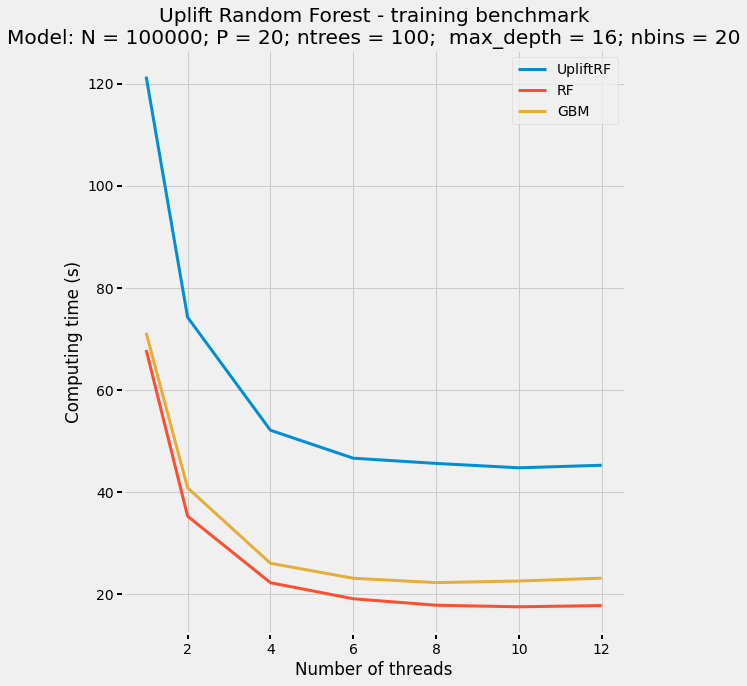

In [24]:
plot_result(uplift_time0, rf_time0, gbm_time0)

In [25]:
N = 100000
P = 20
max_depth = 16
nbins=400
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [26]:
uplift_time1, rf_time1, gbm_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkiulxfdz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkiulxfdz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkiulxfdz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_kaqxms
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 113.15898513793945s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.92165160179138s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.86408305168152s
H2O session _sid_ab91 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpood_56ok
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpood_56ok\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpood_56ok\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_a1sj9k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.16632080078125s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.06157207489014s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.6387870311737s
H2O session _sid_ad79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa8ruanv4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa8ruanv4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa8ruanv4\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_erad9w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.253751039505s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.828513860702515s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.80826807022095s
H2O session _sid_8305 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxro6h3bx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxro6h3bx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxro6h3bx\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_wcikuh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 113.01675462722778s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.40777921676636s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.65111660957336s
H2O session _sid_a832 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3jcemmj5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3jcemmj5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3jcemmj5\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_yky5t4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.49146914482117s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.004323959350586s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.68419933319092s
H2O session _sid_a54e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1g6j5u89
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1g6j5u89\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1g6j5u89\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_0vuc37
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 113.14468288421631s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.99279737472534s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 78.01969385147095s
H2O session _sid_9ef9 closed.
Uplift 113.03866060574849s
RF 35.869439681371055s
gbm 79.94435799121857s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp43labjz6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp43labjz6\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_g75f8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.78960371017456s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.49366593360901s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.49948024749756s
H2O session _sid_9776 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt4nhp35n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt4nhp35n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt4nhp35n\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_m1daxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.40107846260071s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.021387338638306s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.51862049102783s
H2O session _sid_8330 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp03mephe6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp03mephe6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp03mephe6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_6ravuy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.08540081977844s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.37783360481262s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.44242668151855s
H2O session _sid_b3c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzysfikuc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzysfikuc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzysfikuc\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_j0qzga
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.19018197059631s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.06046414375305s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.52208518981934s
H2O session _sid_9eaf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf95vrsvc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf95vrsvc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf95vrsvc\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_kt30ji
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.67125797271729s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.30386543273926s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.68688201904297s
H2O session _sid_b88c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_oo256z_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_oo256z_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_oo256z_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_eqc8ga
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.91286873817444s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.43981671333313s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.6653995513916s
H2O session _sid_a3bc closed.
Uplift 105.50839861234029s
RF 34.28283886114756s
gbm 71.05581569671631s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsyxf63ai
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsyxf63ai\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_oyo1bv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.10738801956177s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.69495344161987s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.8865373134613s
H2O session _sid_b4ff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpodxg03fw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpodxg03fw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpodxg03fw\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_c2ygnu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.37240886688232s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.8755419254303s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 66.44629263877869s
H2O session _sid_b408 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfyz8wvj3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfyz8wvj3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfyz8wvj3\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_62a4qj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.30212950706482s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.63028621673584s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 66.19392943382263s
H2O session _sid_9324 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprpg60iew
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprpg60iew\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprpg60iew\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_65f5yo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.12321782112122s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.0184690952301s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 66.6529552936554s
H2O session _sid_b495 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp15xyvnil
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp15xyvnil\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp15xyvnil\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_k8ysee
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.9464271068573s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.58407020568848s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.97885847091675s
H2O session _sid_b810 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7zw3v7tv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7zw3v7tv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7zw3v7tv\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_u438j3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.79879093170166s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.641637325286865s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.95560073852539s
H2O session _sid_971e closed.
Uplift 103.10839370886485s
RF 32.574159701665245s
gbm 66.01902898152669s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwvkde4gd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwvkde4gd\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_l2891t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.23672199249268s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.481396913528442s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.16634750366211s
H2O session _sid_8d6a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuwl8_lan
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuwl8_lan\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuwl8_lan\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_hhfsq2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.43012189865112s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.770177125930786s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.21965408325195s
H2O session _sid_84d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiyfk_6xn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiyfk_6xn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiyfk_6xn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_cwxevg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.17336845397949s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.559908628463745s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.8923397064209s
H2O session _sid_8b78 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_6h3aj7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_6h3aj7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_6h3aj7\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_uf62nm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.4759783744812s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.489325284957886s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.63994765281677s
H2O session _sid_9d23 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzwtpbgr6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzwtpbgr6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzwtpbgr6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_avsp0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.13748121261597s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.77476668357849s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.631319999694824s
H2O session _sid_97c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb4l1xmhw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb4l1xmhw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb4l1xmhw\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_vmma7j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.28271698951721s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.662625789642334s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.288878202438354s
H2O session _sid_8677 closed.
Uplift 102.28939815362294s
RF 31.78970007101695s
gbm 61.80641452471415s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8wfqnqxt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8wfqnqxt\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_cswalf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.27062749862671s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.936158180236816s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.998268127441406s
H2O session _sid_866f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplyr6226t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplyr6226t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplyr6226t\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_vmtalf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.01177906990051s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.11703038215637s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.172093868255615s
H2O session _sid_9fab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb5gfjolh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb5gfjolh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb5gfjolh\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_hly45z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 110.5367865562439s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.261767864227295s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.090970277786255s
H2O session _sid_9093 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi8meoz6w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi8meoz6w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi8meoz6w\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_cpkpam
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.16908168792725s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.38735556602478s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.070671796798706s
H2O session _sid_ab96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp34hc36mo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp34hc36mo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp34hc36mo\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_j4s3to
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.32941365242004s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.84538698196411s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.33288836479187s
H2O session _sid_a131 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl_ufnnxg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl_ufnnxg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl_ufnnxg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_v558pf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.05119752883911s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.10371375083923s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 59.01657676696777s
H2O session _sid_8a9d closed.
Uplift 109.22814766565959s
RF 34.77523545424143s
gbm 60.780244867006935s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpttw6ahw5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpttw6ahw5\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_vp9e0u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 166.7871732711792s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.00525188446045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.94769740104675s
H2O session _sid_bad3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5vvuhsma
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5vvuhsma\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5vvuhsma\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_eoh3xv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 166.86914110183716s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.13747525215149s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.40146064758301s
H2O session _sid_8961 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps7n7xf0q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps7n7xf0q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps7n7xf0q\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_jabqbf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.38248777389526s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.2001576423645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.402423620224s
H2O session _sid_853b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptxfwykcz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptxfwykcz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptxfwykcz\h2o_potte_started_from_python.err


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tsrcs6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.18578362464905s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.4942352771759s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.41483926773071s
H2O session _sid_bece closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjacfowc9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjacfowc9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjacfowc9\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9drqey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 166.53759717941284s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.311235427856445s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.15675640106201s
H2O session _sid_9030 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1rs5gdh3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1rs5gdh3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1rs5gdh3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_j3svgu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 167.1105992794037s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.86636185646057s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.7157552242279s
H2O session _sid_b2ad closed.
Uplift 167.31213037172952s
RF 53.33578622341156s
gbm 81.83982209364574s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpptq57ho5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpptq57ho5\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jaihog
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 295.07301449775696s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.3172299861908s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 133.80892419815063s
H2O session _sid_8e5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0q7ivovx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0q7ivovx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0q7ivovx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sp8vmu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.48503398895264s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.05856680870056s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.03553915023804s
H2O session _sid_95b8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo6_1pek_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo6_1pek_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo6_1pek_\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ra2dzl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.3792324066162s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.88240385055542s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 130.48877000808716s
H2O session _sid_85ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmposalprlw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmposalprlw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmposalprlw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wkgmo9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.3890883922577s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.59926891326904s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 133.5921368598938s
H2O session _sid_b309 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppnl0aygo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppnl0aygo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppnl0aygo\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cb10j9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 300.60850071907043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.24984502792358s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.90293955802917s
H2O session _sid_b4d5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvjgkmch2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvjgkmch2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvjgkmch2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6rhsw8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.1525659561157s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.25154662132263s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 129.60393929481506s
H2O session _sid_9b30 closed.
Uplift 297.5145726601283s
RF 98.39314353466034s
gbm 132.7387081782023s
12 - Uplift = 113.03866060574849, RF = 35.869439681371055, gbm = 79.94435799121857
10 - Uplift = 105.50839861234029, RF = 34.28283886114756, gbm = 71.05581569671631
8 - Uplift = 103.10839370886485, RF = 32.574159701665245, gbm = 66.01902898152669
6 - Uplift = 102.28939815362294, RF = 31.78970007101695, gbm = 61.80641452471415
4 - Uplift = 109.22814766565959, RF = 34.77523545424143, gbm = 60.780244867006935
2 - Uplift = 167.31

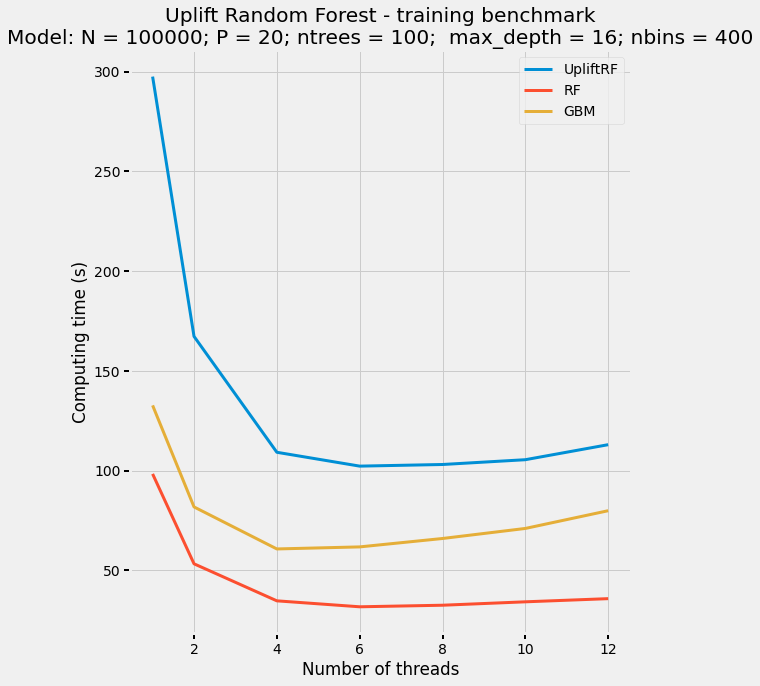

In [27]:
plot_result(uplift_time1, rf_time1, gbm_time1)

In [28]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=2000
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [31]:
uplift_time2, rf_time2, gbm_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprg_7dsvu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprg_7dsvu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprg_7dsvu\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4vlap8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 385.07531666755676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.13829135894775s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 297.33533906936646s
H2O session _sid_b0cd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprwbhm6en
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprwbhm6en\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprwbhm6en\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_iirifr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.09887313842773s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.12672805786133s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 293.23879647254944s
H2O session _sid_aa7c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmj9s1uup
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmj9s1uup\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmj9s1uup\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mney4m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 377.99142241477966s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.11030507087708s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 295.54156708717346s
H2O session _sid_9d63 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppxdjxing
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppxdjxing\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppxdjxing\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2fzgm8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 380.5119824409485s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.94700694084167s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 293.72951674461365s
H2O session _sid_a05e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps9dyn9x2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps9dyn9x2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps9dyn9x2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8uye6p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 379.4583435058594s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.74256753921509s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 298.036025762558s
H2O session _sid_8ef8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5n61h79t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5n61h79t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5n61h79t\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_agbhvr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.88485383987427s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.79488492012024s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 294.8109543323517s
H2O session _sid_a028 closed.
Uplift 380.3367986679077s
RF 106.97663064797719s
gbm 295.4486999114354s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8bh6777o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8bh6777o\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zixwk2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 342.1257791519165s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.56196999549866s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 270.37557578086853s
H2O session _sid_93eb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp53usyow9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp53usyow9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp53usyow9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tf6nl4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 351.368399143219s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.34710144996643s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 268.9774043560028s
H2O session _sid_bd09 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpznztrdpg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpznztrdpg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpznztrdpg\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_060mkg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 341.6454417705536s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.90510272979736s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 271.6953294277191s
H2O session _sid_b73e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2w8ezoqv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2w8ezoqv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2w8ezoqv\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4xlv3n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 344.1366205215454s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.25514459609985s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 270.10304737091064s
H2O session _sid_9a5a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpccpg_nj8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpccpg_nj8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpccpg_nj8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ybs4w8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 349.32634568214417s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.94117593765259s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 270.17728996276855s
H2O session _sid_911c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx56nqixq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx56nqixq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx56nqixq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_l8zyde
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 344.99957394599915s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.71638894081116s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 271.201721906662s
H2O session _sid_90df closed.
Uplift 345.6003600358963s
RF 98.62114727497101s
gbm 270.4217281341553s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmewtk0ng
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmewtk0ng\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qcmrly
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 321.8306541442871s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.62948298454285s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 246.12655067443848s
H2O session _sid_bf43 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8xouo_xk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8xouo_xk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8xouo_xk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_t71qg7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 329.22654962539673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.55738091468811s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.46188163757324s
H2O session _sid_8131 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv470tw12
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv470tw12\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv470tw12\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_od0dg1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 327.67708134651184s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.5553023815155s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 246.86782932281494s
H2O session _sid_8a99 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7yule0n_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7yule0n_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7yule0n_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5uriih
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 324.2958059310913s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.61079359054565s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.97242522239685s
H2O session _sid_806e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpup392mys
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpup392mys\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpup392mys\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_02beqg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 321.7637462615967s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.60357928276062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 248.27896332740784s
H2O session _sid_8cf8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplu1up0fx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplu1up0fx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplu1up0fx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7dwsls
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 329.2412989139557s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.94709086418152s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 248.02904319763184s
H2O session _sid_93f6 closed.
Uplift 325.6725227038066s
RF 91.3172716697057s
gbm 246.78944889704385s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9__2fiss
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9__2fiss\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p03lo7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 310.666631937027s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.90704894065857s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.39332008361816s
H2O session _sid_8bab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfzh50r2v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfzh50r2v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfzh50r2v\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lic5sm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 304.0457148551941s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.05358219146729s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 225.72614407539368s
H2O session _sid_9842 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwffaskgg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwffaskgg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwffaskgg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d5tljc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.4199607372284s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.82015323638916s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.0202283859253s
H2O session _sid_90b6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppxx1kohs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppxx1kohs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppxx1kohs\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bo1il5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.62639808654785s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.97517442703247s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.87838554382324s
H2O session _sid_839f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqhj8kny4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqhj8kny4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqhj8kny4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xtnsn6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 303.7650909423828s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.8212342262268s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 225.48461031913757s
H2O session _sid_bce3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpau620amd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpau620amd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpau620amd\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_92wqjy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.44166707992554s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.84361100196838s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.53914856910706s
H2O session _sid_932c closed.
Uplift 305.9942439397176s
RF 84.40346733729045s
gbm 223.84030616283417s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2hj9qtk2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2hj9qtk2\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gdvjsi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.27442145347595s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.16358184814453s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.76982760429382s
H2O session _sid_9811 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfuocf_14
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfuocf_14\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfuocf_14\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sdo3eh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.73846983909607s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.72141432762146s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.511088848114s
H2O session _sid_9745 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp47_t5w3w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp47_t5w3w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp47_t5w3w\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dhn4m7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.4142601490021s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.87632274627686s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.20595860481262s
H2O session _sid_a29c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp54ac0jxk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp54ac0jxk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp54ac0jxk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2o12q9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.93536496162415s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.08985686302185s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 208.38327550888062s
H2O session _sid_896d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp182lfe0b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp182lfe0b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp182lfe0b\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dpfovx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.64366126060486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.23674511909485s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.20990085601807s
H2O session _sid_b0e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4scx8ixj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4scx8ixj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4scx8ixj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_66d5zf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.24922919273376s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.97703218460083s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.5047311782837s
H2O session _sid_aa35 closed.
Uplift 296.7092344760895s
RF 85.34415884812672s
gbm 207.43079710006714s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbvnk9nxt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbvnk9nxt\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wf5hel
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 398.71544075012207s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.71800374984741s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.21765780448914s
H2O session _sid_9312 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg113fs4g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg113fs4g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg113fs4g\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gx2ij0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 401.43314146995544s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 116.86165404319763s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.44350600242615s
H2O session _sid_a3e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnxf1lcbu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnxf1lcbu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnxf1lcbu\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_71jhhx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 393.2604100704193s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 120.85636615753174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.98629093170166s
H2O session _sid_85a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgn61rfl_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgn61rfl_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgn61rfl_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7dsho7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.8068609237671s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 121.20132994651794s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.8136637210846s
H2O session _sid_8f7c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcm9ahgra
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcm9ahgra\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcm9ahgra\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kal033
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.3915274143219s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.6314308643341s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.18197059631348s
H2O session _sid_91bd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp03f_1_wd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp03f_1_wd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp03f_1_wd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7qr2qk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 401.4207947254181s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.80304527282715s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.38857507705688s
H2O session _sid_815e closed.
Uplift 399.3380292256673s
RF 119.84530500570933s
gbm 239.3386106888453s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2gfgir8n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2gfgir8n\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rx7zt3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 673.1212306022644s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 220.31129240989685s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 354.487761259079s
H2O session _sid_b97c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppyxbjqlc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppyxbjqlc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppyxbjqlc\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0bw2fo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 674.7368106842041s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 218.1647825241089s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 365.17368388175964s
H2O session _sid_8dd2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpngwzhasd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpngwzhasd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpngwzhasd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v7miw8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 681.5640897750854s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 222.43818402290344s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 357.06950855255127s
H2O session _sid_9218 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp27nas5w8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp27nas5w8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp27nas5w8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bnfewz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 678.9627463817596s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 220.10383009910583s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 360.4280240535736s
H2O session _sid_9a43 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbxd1x7zd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbxd1x7zd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbxd1x7zd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8j6180
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 667.227073431015s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 221.708393573761s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 353.967885017395s
H2O session _sid_a035 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwwopvppf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwwopvppf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwwopvppf\h2o_potte_started_from_python.err
 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zirm0w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 672.5753149986267s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 220.2230920791626s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 353.9317696094513s
H2O session _sid_b8e7 closed.
Uplift 674.6978776454926s
RF 220.4915957848231s
gbm 357.50977206230164s
12 - Uplift = 380.3367986679077, RF = 106.97663064797719, gbm = 295.4486999114354
10 - Uplift = 345.6003600358963, RF = 98.62114727497101, gbm = 270.4217281341553
8 - Uplift = 325.6725227038066, RF = 91.3172716697057, gbm = 246.78944889704385
6 - Uplift = 305.9942439397176, RF = 84.40346733729045, gbm = 223.84030616283417
4 - Uplift = 296.7092344760895, RF = 85.34415884812672, gbm = 207.43079710006714
2 - Uplift = 399.3380292

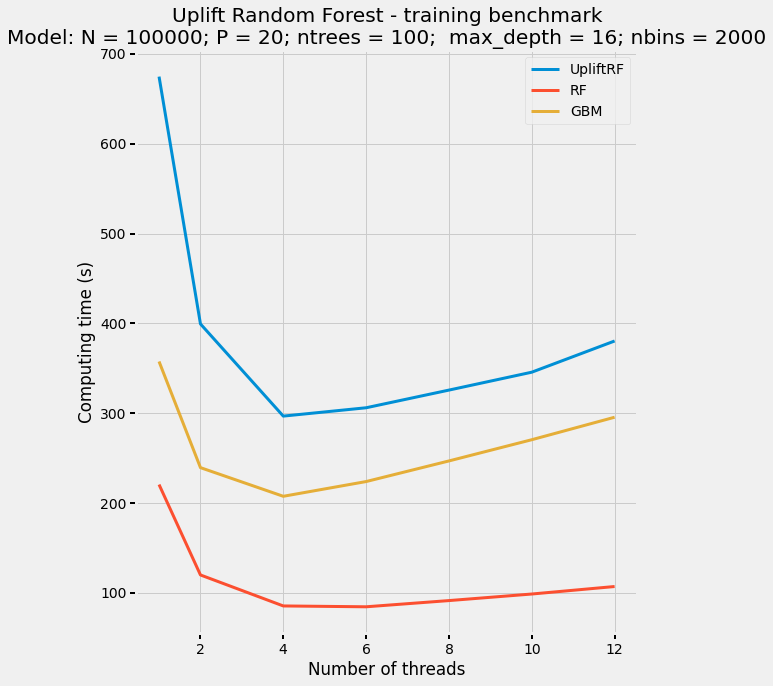

In [32]:
plot_result(uplift_time2, rf_time2, gbm_time2)

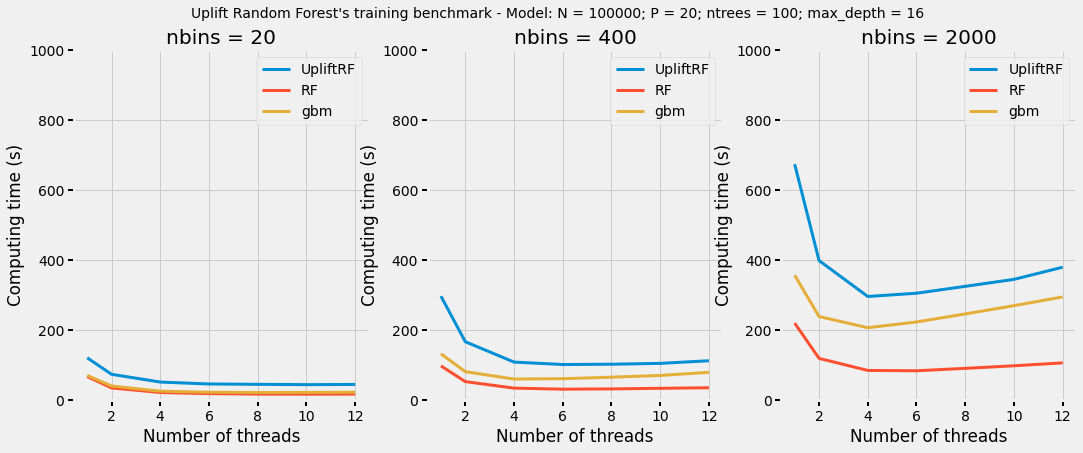

In [33]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"gbm", linewidth=3)    
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [34]:
print(all_predict_uplift)

[{12: 45.2544960975647, 10: 44.75494519869486, 8: 45.61311427752177, 6: 46.6379341284434, 4: 52.11662983894348, 2: 74.25968396663666, 1: 121.41705004374187}, {12: 113.03866060574849, 10: 105.50839861234029, 8: 103.10839370886485, 6: 102.28939815362294, 4: 109.22814766565959, 2: 167.31213037172952, 1: 297.5145726601283}, {12: 380.3367986679077, 10: 345.6003600358963, 8: 325.6725227038066, 6: 305.9942439397176, 4: 296.7092344760895, 2: 399.3380292256673, 1: 674.6978776454926}]


In [35]:
print(all_predict_rf)

[{12: 17.760190447171528, 10: 17.516754150390625, 8: 17.822417100270588, 6: 19.09000547726949, 4: 22.239211757977802, 2: 35.28043739000956, 1: 67.85712361335754}, {12: 35.869439681371055, 10: 34.28283886114756, 8: 32.574159701665245, 6: 31.78970007101695, 4: 34.77523545424143, 2: 53.33578622341156, 1: 98.39314353466034}, {12: 106.97663064797719, 10: 98.62114727497101, 8: 91.3172716697057, 6: 84.40346733729045, 4: 85.34415884812672, 2: 119.84530500570933, 1: 220.4915957848231}]


In [36]:
print(all_predict_gbm)

[{12: 23.125603596369427, 10: 22.572927196820576, 8: 22.25787838300069, 6: 23.107598106066387, 4: 26.047218084335327, 2: 40.83299307028452, 1: 71.21424233913422}, {12: 79.94435799121857, 10: 71.05581569671631, 8: 66.01902898152669, 6: 61.80641452471415, 4: 60.780244867006935, 2: 81.83982209364574, 1: 132.7387081782023}, {12: 295.4486999114354, 10: 270.4217281341553, 8: 246.78944889704385, 6: 223.84030616283417, 4: 207.43079710006714, 2: 239.3386106888453, 1: 357.50977206230164}]


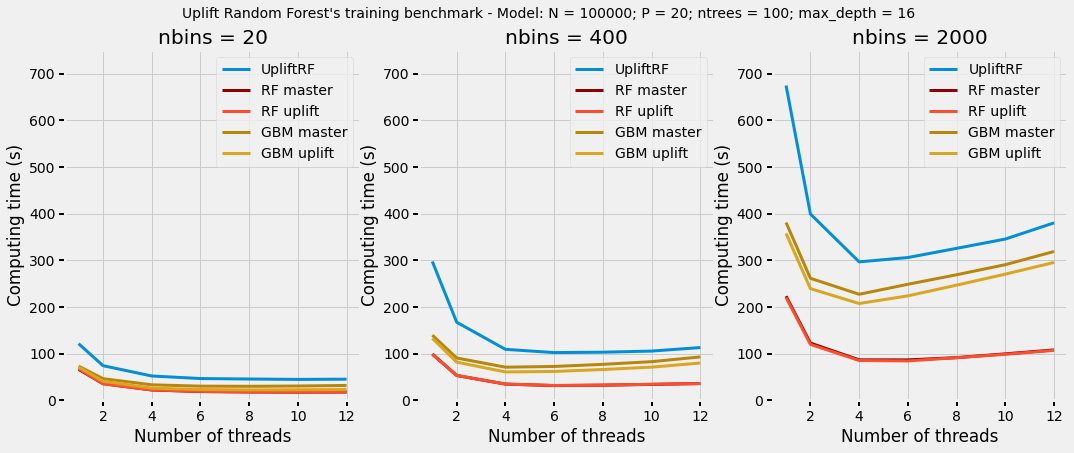

In [39]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf_uplift = [rf_time0, rf_time1, rf_time2]
all_predict_gbm_uplift = [gbm_time0, gbm_time1, gbm_time2]
all_predict_gbm_master = [{12: 31.862845540046692, 10: 30.614763418833416, 8: 29.989627877871197, 6: 30.31572099526723, 4: 33.20208215713501, 2: 46.41166512171427, 1: 73.19678485393524}, {12: 93.00183880329132, 10: 82.78712022304535, 8: 77.07395839691162, 6: 72.52392625808716, 4: 71.00197788079579, 2: 90.70613944530487, 1: 139.66316723823547}, {12: 318.9730988740921, 10: 290.67971273263294, 8: 269.090940117836, 6: 248.68064439296722, 4: 227.22152415911356, 2: 261.5269816716512, 1: 381.06612666447955}]
all_predict_rf_master = [{12: 17.77284888426463, 10: 17.429598371187847, 8: 17.940160473187763, 6: 18.716358304023743, 4: 22.17215351263682, 2: 35.6810447772344, 1: 66.26945110162099}, {12: 35.960758129755654, 10: 34.10555390516917, 8: 32.401920000712074, 6: 31.51007314523061, 4: 34.73041105270386, 2: 53.176997462908425, 1: 99.16723815600078}, {12: 107.9198621114095, 10: 99.52437174320221, 8: 91.43911516666412, 6: 86.58242483933766, 4: 86.6784698565801, 2: 122.56513651212056, 1: 223.16886381308237}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color = "darkgoldenrod")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")      
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 750)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

## Evaluation Stage

In [ ]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth+1)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        
    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])

    return eif_means, if_means 

def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [ ]:
# Evaluation stage parameters

N = 500
P = 2
N_train = 500
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time18, if_time18 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time18, if_time18)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 30
N_train = 500_000
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time10, if_time10 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time10, if_time10)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 5_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time11, if_time11 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time11, if_time11)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 20_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time12, if_time12 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time12, if_time12)

### Real Credit Card Fraud Detection Data

In [ ]:
sample_sizes = []

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = 256
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time14, if_time14 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time14, if_time14)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time15, if_time15 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time15, if_time15)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time16, if_time16 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time16, if_time16)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.10)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time17, if_time17 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time17, if_time17)

In [ ]:
all_predict_eif = [eif_time14, eif_time15, eif_time16]
all_predict_if = [if_time14, if_time15, if_time16]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Extended Isolation Forest's scoring benchmark - Frame to score: N = {N}; P = {P}. Model: N = {N_train}; P = {P}; ntrees = {ntrees}.", fontsize=14)

for eif_time, if_time, i in zip(all_predict_eif, all_predict_if, range(1, len(sample_sizes) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"EIF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in if_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"IF", linewidth=3)    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 40)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"sample_size = {sample_sizes[i - 1]}; max_depth = {math.ceil(math.log(sample_sizes[i - 1], 2))}")

plt.savefig(f"h2o-score-perf_credit{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()